<a href="https://colab.research.google.com/github/Zachary-Higgins/jupyterlab-collection/blob/main/notebooks/sar/howto-sarpy_subaperture_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SAR Sub Aperture Calculation Experiment**

In [2]:
!pip install git+https://github.com/ngageoint/sarpy

  Cloning https://github.com/ngageoint/sarpy to /tmp/pip-req-build-g_ykl7n5
  Running command git clone --filter=blob:none --quiet https://github.com/ngageoint/sarpy /tmp/pip-req-build-g_ykl7n5
  Resolved https://github.com/ngageoint/sarpy to commit 11d19a0440725181678cff89873c6f2315c6a96d
  Preparing metadata (setup.py) ... done
  Created wheel for sarpy: filename=sarpy-1.3.58-py2.py3-none-any.whl size=1629170 sha256=8a8cf1fd893db3b725566325a017a51a22f003dd1fe31eac073da8d1b0fa92fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-rrrvszzu/wheels/16/2b/8a/02273ac3890a77b8a2fe16ea8f4be37fc3184f4298fa83b831
Successfully built sarpy


To open a local file, replace the following cell with:

```
from sarpy.io.complex.converter import open_complex
reader = open_complex('..') #LOCAL FILE
```



In [9]:
from sarpy.io.complex.sicd import SICDReader
import smart_open
file_object = smart_open.open(
    'https://six-library-github-public.s3.us-east-2.amazonaws.com/sicd_example_1_PFA_RE32F_IM32F_VV.nitf',
    mode='rb',  # must be opened in binary mode
    buffering=4*1024*1024)  # it has been observed that setting a manual buffer size may help

reader = SICDReader(file_object)

print(f"Max Columns: {reader.sicd_meta.ImageData.NumCols}")
print(f"Max Rows: {reader.sicd_meta.ImageData.NumRows}")

Max Columns: 6679
Max Rows: 3859


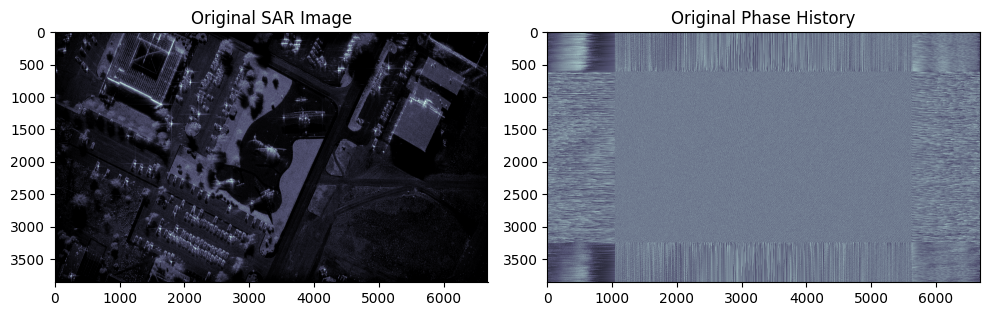

In [11]:
#GET ORIGINAL SAR IMAGE
from matplotlib import pyplot
from sarpy.visualization.remap import Density

#SET BOUNDING BOX
#Replace bounding box coordinates to process smaaller portion of image.
y1 = 0
y2 = reader.sicd_meta.ImageData.NumCols
x1 = 0
x2 = reader.sicd_meta.ImageData.NumRows

remap_function = Density()
chip = reader[y1:y2, x1:x2]

fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 10))

#GET PHASE HISTORY
from sarpy.processing.sicd.subaperture import ApertureFilter
import numpy as np
subaperture_calculator = ApertureFilter(reader)
subaperture_calculator.set_sub_image_bounds((y1, y2), (x1, x2))
subaperture_calculator._set_normalized_phase_history()
phase_history = subaperture_calculator.normalized_phase_history

# Display the original SAR image
axs[0].imshow(remap_function(chip), cmap='bone')
axs[0].set_title('Original SAR Image')

# Display the original phase history
axs[1].imshow(np.angle(phase_history), cmap='bone')
axs[1].set_title('Original Phase History')

pyplot.tight_layout()
pyplot.show()

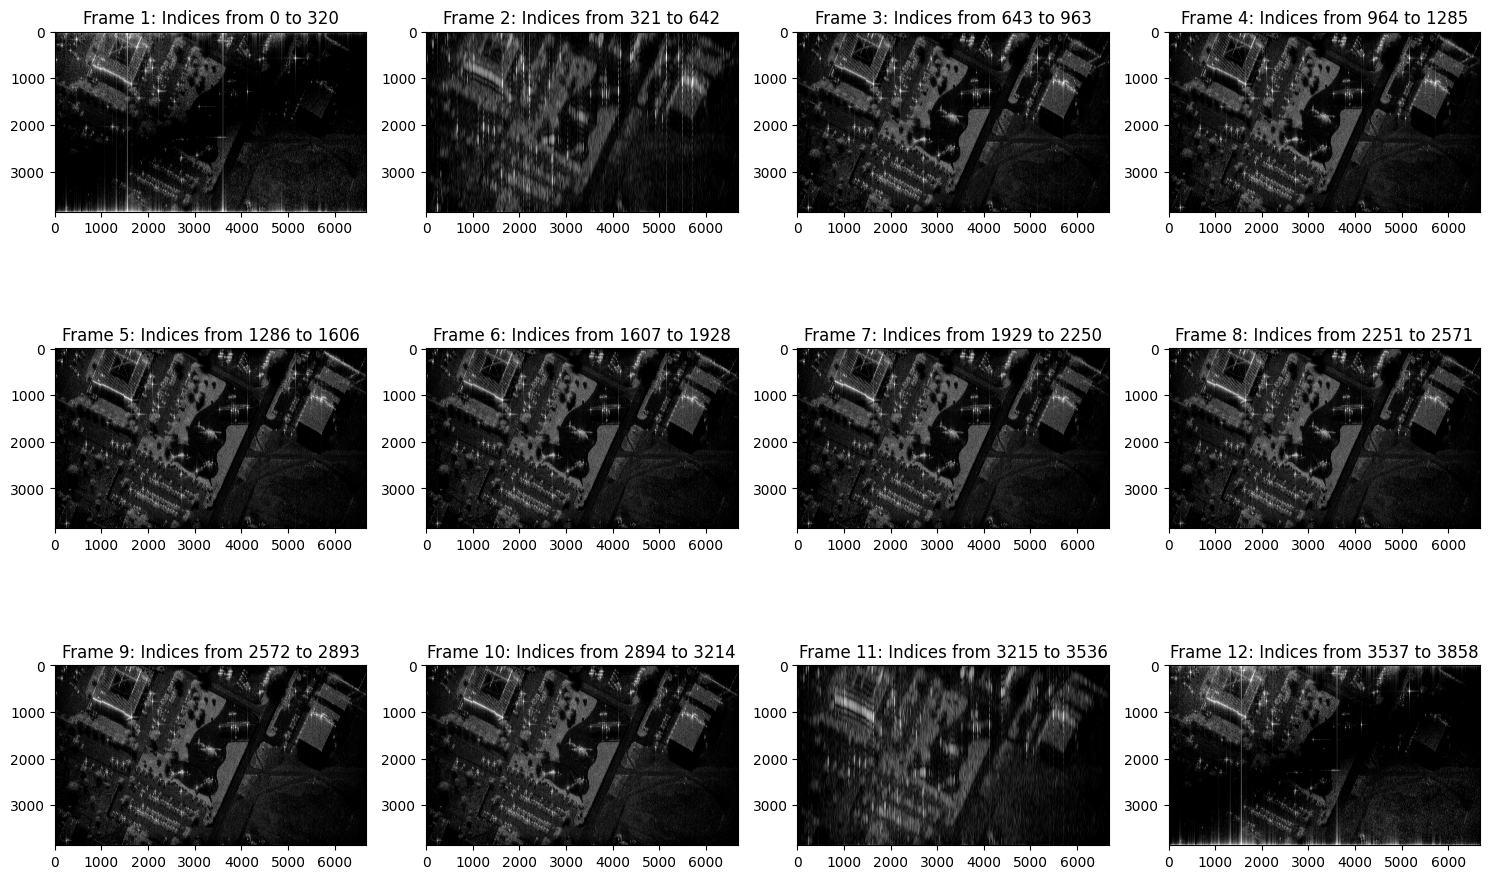

In [12]:
from sarpy.processing.sicd.subaperture import subaperture_processing_array

num_frames = 12
i_coef = len(phase_history)/num_frames

ncols = 4
nrows = int(12/ncols)

fig, axs = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i in range(num_frames):
    start_idx = int(i_coef * i)
    end_idx = int(i_coef * (i + 1))
    result = subaperture_processing_array(chip, [start_idx, end_idx], len(phase_history))

    row = i // ncols
    col = i % ncols

    axs[row, col].imshow(remap_function(result), cmap='gray')
    axs[row, col].set_title(f"Frame {i + 1}: Indices from {start_idx} to {end_idx - 1}")


pyplot.tight_layout()
pyplot.show()